In [1]:
import pandas as pd
import numpy as np
import wordcloud
import skimage.io
import skimage.transform
from skimage.filters import threshold_otsu
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import string
from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline

#### Как известно из новостей (http://www.reuters.com/article/us-usa-election-cyber-idUSKCN1220SL), кибер атаки на US election system любимое развлечение русских хакеров. Особенно, что выборы вот-вот состоятся.

Самостоятельно почитать переписку Хиллари Клинтон можно здесь: https://wikileaks.org/clinton-emails/. Есть даже готовый subset на kaggle: https://www.kaggle.com/kaggle/hillary-clinton-emails. Но анализ, который я делал для этих данных попадает под ШАДовский NDA, поэтому сегодня займемся другим сетом, но тоже про выборы. 26 сентября состоялись дебаты. Транскрипт здесь: https://www.kaggle.com/mrisdal/2016-us-presidential-debates Там же предложены некоторые вопросы, которые можно извлечь из данных. 

Соберем все сказанное кандидатами в облако тегов на фоне их портретов. Может из этого нельзя сделать каких-то крутых выводов, но получится зачетная картинка Clinton vs Trump.

Вот такие исходные фото я нашел:

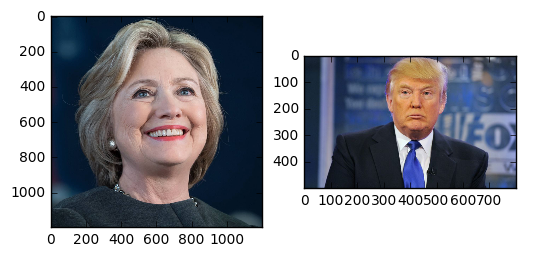

In [2]:
hillary = skimage.io.imread('hillary.jpg')
donald = skimage.io.imread('donald.jpg')
_, ax = plt.subplots(1, 2)
ax[0].imshow(hillary)
ax[1].imshow(donald)

Приведем их к общему знаменателю.

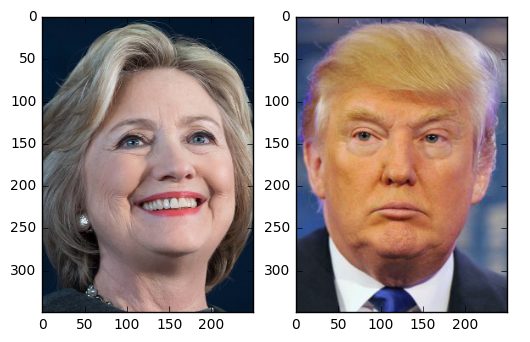

In [3]:
hillary = skimage.io.imread('hillary.jpg')
donald = skimage.io.imread('donald.jpg')

hillary = skimage.transform.resize(hillary[:1050, 200:950], (350, 250))
donald = donald[:350, 300:550]
_, ax = plt.subplots(1, 2)
ax[0].imshow(hillary)
ax[1].imshow(donald)

А вот head транскрипта

In [4]:
df = pd.read_csv('debates2016.csv')
df.head()

,Line,Speaker,Text,Date
0,1,Holt,Good evening from Hofstra University in Hempst...,2016-09-26
1,2,Audience,(APPLAUSE),2016-09-26
2,3,Clinton,"How are you, Donald?",2016-09-26
3,4,Audience,(APPLAUSE),2016-09-26
4,5,Holt,Good luck to you.,2016-09-26


Соберем все вместе:

In [5]:
def cloud_img(df, img):
    remove_punkt = re.compile('[{}]'.format(re.escape(string.punctuation)))
    stop_words = stopwords.words('english')
    porter = PorterStemmer()
    corpus = df.Text
    corpus = corpus.apply(lambda doc: remove_punkt.sub('', doc))
    corpus = corpus.apply(lambda doc: ' '.join([porter.stem(word.decode('utf8').lower()) 
                                                for word in doc.split()]))
    corpus = corpus.apply(lambda doc: ' '.join([word for word in doc.split()
                                                if word not in stop_words]))
    corpus = ' '.join(corpus.values)
    
    img = skimage.color.rgb2gray(img)
    threshold = threshold_otsu(img)
    bwimg = (img < threshold).astype(np.uint8) * 255
    
    stop_words = {'go', 'wa', 'becaus', 'hillari', 'clinton', 'donald'}
    wc = WordCloud(background_color='white', 
                   max_words=300, 
                   stopwords=stop_words, 
                   mask=bwimg)
    wordcloud = wc.generate(corpus).to_array()
    overlay = np.ones((img.shape[0], img.shape[1], 4))
    overlay[:, :, 3] *= ~bwimg / 255
    overlay[:, :, 0:3] = wordcloud
    return overlay

Слова нормализованы леммером, поэтому есть странные написания типа veri и countri. Зато такая штука помогает учесть все производные слова вместе.

[]

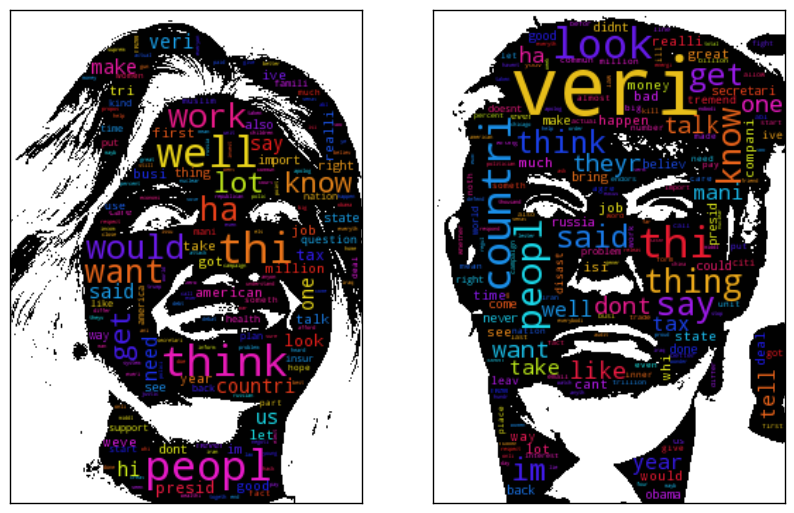

In [6]:
hillary_cloud = cloud_img(df[df.Speaker == 'Clinton'], hillary)
donald_cloud = cloud_img(df[df.Speaker == 'Trump'], donald)

_, ax = plt.subplots(1, 2, figsize=(10, 8))    
ax[0].imshow(hillary_cloud)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(donald_cloud)
ax[1].set_xticks([])
ax[1].set_yticks([])

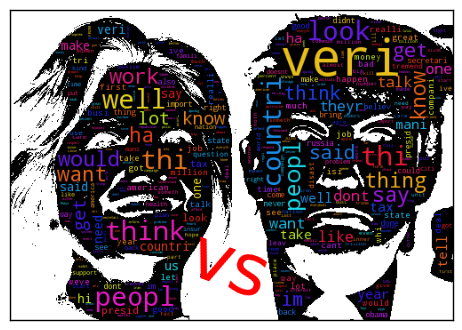

In [7]:
plt.imshow(np.hstack([hillary_cloud, donald_cloud]))
plt.text(190, 300, 'vs', {'color': 'red', 'rotation': -20, 'size': 52})
plt.xticks([])
plt.yticks([])
pass